In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import pickle
import scipy.io
from os.path import dirname, abspath
import os
import sys
sys.path.append(dirname(dirname(dirname(abspath('__file__')))))

from utils.plr_segmentation import PLR_seg_reg, PLR_seg_inter, draw_segments
from utils.read_answers import ReadAnswers
from utils.check_performance import checkPerformance

%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
## Input the filenames and parameters:
filename = 'AmsData_lage_measurements_all.pkl'  # 'AmsData_hoge_corrected_int_all.pkl'  #'AmsData_hoge_corrected_int_all.pkl'  # 'AmsData_hoge_measurements_all.pkl' 
original_indices = 'orig_x.npy'
filename_answers = 'lage_segm_lines_31052020.txt'
interpolation_method = 'linear'
filename_stds = 'stds.pkl'

In [3]:
## Create variables with directories to external files:
directory = os.path.join(dirname(dirname(os.getcwd())), 'data_files/')
file_data = os.path.join(directory, filename)
file_orig_indices = os.path.join(directory, original_indices)
file_answers = os.path.join(directory, filename_answers)
file_stds = os.path.join(directory, filename_stds)

In [5]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data = data_imported[interpolation_method].copy()

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
answers = ReadAnswers(file_answers)
ans = pd.DataFrame(answers['segm_lines'], index = answers.index)
ans.columns = ['segm']
## For full time T-S:
ans_full = ans.copy()
for i in range(100):
    ans_full.segm.iloc[i] = [indices[y] for y in ans_full.segm.iloc[i]]

## Mask to choose only the examples with provided GT (ground truth):
mask_segm = ans.segm.apply(lambda x: x != [])
ans[mask_segm]
ans_segm_only = ans.iloc[np.where(mask_segm)[0]]
mydata_segm_only = data.iloc[ans.index[np.where(mask_segm)[0]]].copy()

## Load standadr deviation values for all T-S:
with open(file_stds, 'rb') as file:
    stds = pickle.load(file)
std_al_orig, std_al_detr, atd_ah_orig, std_ah_detr = stds

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

In [19]:
# def calculate_score_PLR_all(data, ans, std_list, coeff, tolerance=5, verbose=True):
def calculate_score_PLR_all(inp_data, ans, error, tolerance=5, verbose=True):    
    plr_sw = []
    plr_bu = []
    plr_td = []

    for i in range(100):
        ts_num = i
        data = inp_data.iloc[ans.index[ts_num]].values
#         std = std_list[ans.index[ts_num]]
        max_error = error #coeff * std
#         max_error = coeff * std
        
        _, plr = PLR_seg_reg(data, max_error)
#         _, plr = PLR_seg_inter(data, max_error)

        plr_sw.append(plr[0])
        plr_bu.append(plr[1])
        plr_td.append(plr[2])


#     methods = ['PLR Sliding Window', 'PLR Bottom-Up', 'PLR Top-Down']
#     answers = [plr_sw, plr_bu, plr_td]
    plr_sw2 = []
    plr_bu2 = []
    plr_td2 = []   
    
    for line in plr_sw:
        tmp = [indices_reverse[x] for x in line]
        plr_sw2.append(tmp)
    for line in plr_bu:
        tmp = [indices_reverse[x] for x in line]
        plr_bu2.append(tmp)
    for line in plr_td:
        tmp = [indices_reverse[x] for x in line]
        plr_td2.append(tmp)
    
    methods = ['PLR Sliding Window', 'PLR Bottom-Up', 'PLR Top-Down', 'PLR Sliding Window 2', 'PLR Bottom-Up 2', 'PLR Top-Down 2']
    answers = [plr_sw, plr_bu, plr_td, plr_sw2, plr_bu2, plr_td2]

    recalls = {}
    precisions = {}
    TPall = {}
    FPall = {}
    FNall = {}
    for m in methods:
        recalls[m] = []
        precisions[m] = []
        TPall[m] = []
        FPall[m] = []
        FNall[m] = []

    for i, m in enumerate(methods):
        for l in range(100):
            r, p, tp, fp, fn = checkPerformance(answers[i][l], ans.segm.iloc[l], tolerance = 5)
            recalls[m].append(r)
            precisions[m].append(p)
            TPall[m].append(tp)
            FPall[m].append(fp)
            FNall[m].append(fn)
        
    result = []
    for m in methods:
        result.append((sum(TPall[m])/(sum(TPall[m]) + sum(FNall[m])), sum(TPall[m])/(sum(TPall[m]) + sum(FPall[m]))))
#         result.append((float(format(np.nanmean(recalls[m]), '.4f')), float(format(np.nanmean(precisions[m]), '.4f'))))
        
    if verbose:
        print("----------------------------------")
        print("Max error = ", max_error, "\n")
        for j in range(len(result)):
            print(methods[j])
            print("recall: ", result[j][0])
            print("precision: ", result[j][1], "\n")
        for m in methods: 
            print(m)
            print('recall:', np.nanmean(recalls[m]))
            print('precision:',np.nanmean(precisions[m]), '\n')
            print('non nans for prec.:', np.count_nonzero(~np.isnan(precisions[m])))
            print()
            print('TPall: ', sum(TPall[m]))
            print('FPall: ', sum(FPall[m]))
            print('FNall: ', sum(FNall[m]))
            print()
            print('recall:',sum(TPall[m])/(sum(TPall[m]) + sum(FNall[m])))
            print('precision:',sum(TPall[m])/(sum(TPall[m]) + sum(FPall[m])), '\n')
            print('-------------------------------------')
            
    with open('PLR_results_linear_plot.txt', 'a') as f:
#     with open('PLR_results_AL_22_06.txt', 'a') as f:
        for m in methods: 
#             f.write('Error: ' + str(max_error)+' | coeff: '+ str(coeff)+ '\n\n')
            f.write('Error: ' + str(max_error)+ '\n\n')
            f.write(str(m)+ '\n')
            f.write('recall: ' + str(np.nanmean(recalls[m]))+ '\n')
            f.write('precision: ' + str(np.nanmean(precisions[m])) + '\n')
            f.write('non nans for prec.: ' +  str(np.count_nonzero(~np.isnan(precisions[m])))+ '\n')
            f.write('\n')
            f.write('TPall: ' + str(sum(TPall[m]))+ '\n')
            f.write('FPall: ' + str(sum(FPall[m]))+ '\n')
            f.write('FNall: ' + str(sum(FNall[m]))+ '\n')
            f.write('\n')
            f.write('recall: ' + str(sum(TPall[m])/(sum(TPall[m]) + sum(FNall[m]))) + '\n')
            f.write('precision: ' + str(sum(TPall[m])/(sum(TPall[m]) + sum(FPall[m]))) + '\n')
            f.write('-------------------------------------\n')
            
    return result

In [7]:
sum(std_al_detr)/len(std_al_detr)

2.7496867375526923

In [8]:
sum(std_al_orig)/len(std_al_orig)

5.44819036995376

In [21]:
all_results = {}
for k in range(21,26):
# for i in [500, 600, 700]:
    i = k*100
    tmp = calculate_score_PLR_all(data, ans_full, i, verbose=False)
#     tmp = calculate_score_PLR_all(data, ans_full, std_ah_detr, i)
    all_results[i] = tmp

In [12]:
all_results

{100: [(0.7007299270072993, 0.07084870848708487),
  (0.6131386861313869, 0.0691358024691358),
  (0.8686131386861314, 0.05997983870967742),
  (0.708029197080292, 0.07158671586715867),
  (0.6131386861313869, 0.0691358024691358),
  (0.8686131386861314, 0.06040609137055838)],
 200: [(0.49635036496350365, 0.09006622516556291),
  (0.4233576642335766, 0.0836940836940837),
  (0.7445255474452555, 0.09002647837599294),
  (0.49635036496350365, 0.09006622516556291),
  (0.4233576642335766, 0.0836940836940837),
  (0.7445255474452555, 0.09050576752440107)],
 300: [(0.3357664233576642, 0.08695652173913043),
  (0.34306569343065696, 0.09832635983263599),
  (0.6861313868613139, 0.11706102117061021),
  (0.34306569343065696, 0.0888468809073724),
  (0.34306569343065696, 0.09832635983263599),
  (0.6861313868613139, 0.11735330836454431)],
 400: [(0.3161764705882353, 0.10886075949367088),
  (0.30656934306569344, 0.11731843575418995),
  (0.6642335766423357, 0.14942528735632185),
  (0.33088235294117646, 0.113924

ans:  segm    [72, 36, 23]
Name: 137, dtype: object
ans:  [87, 39, 24]
ans:  segm    [87, 39, 24]
Name: 137, dtype: object
0
5
6
63
123
262


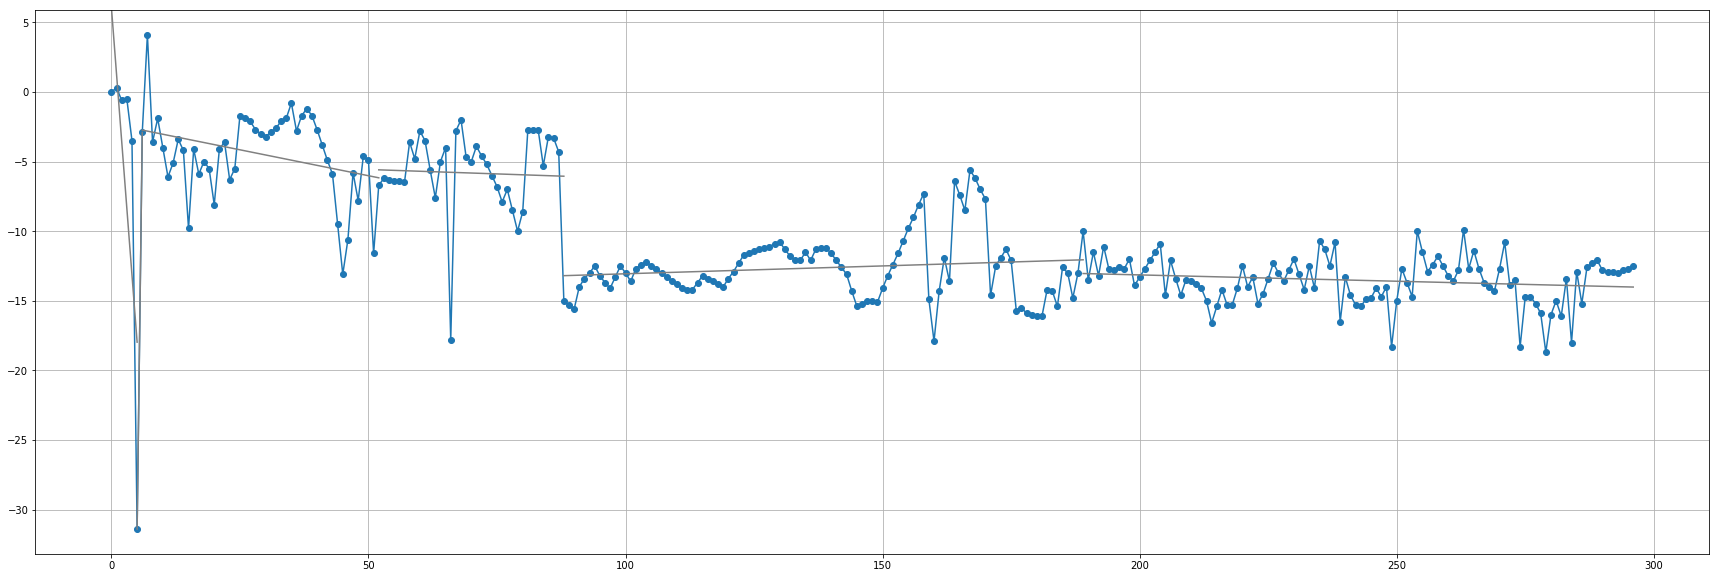

0
5
9
79
133
253


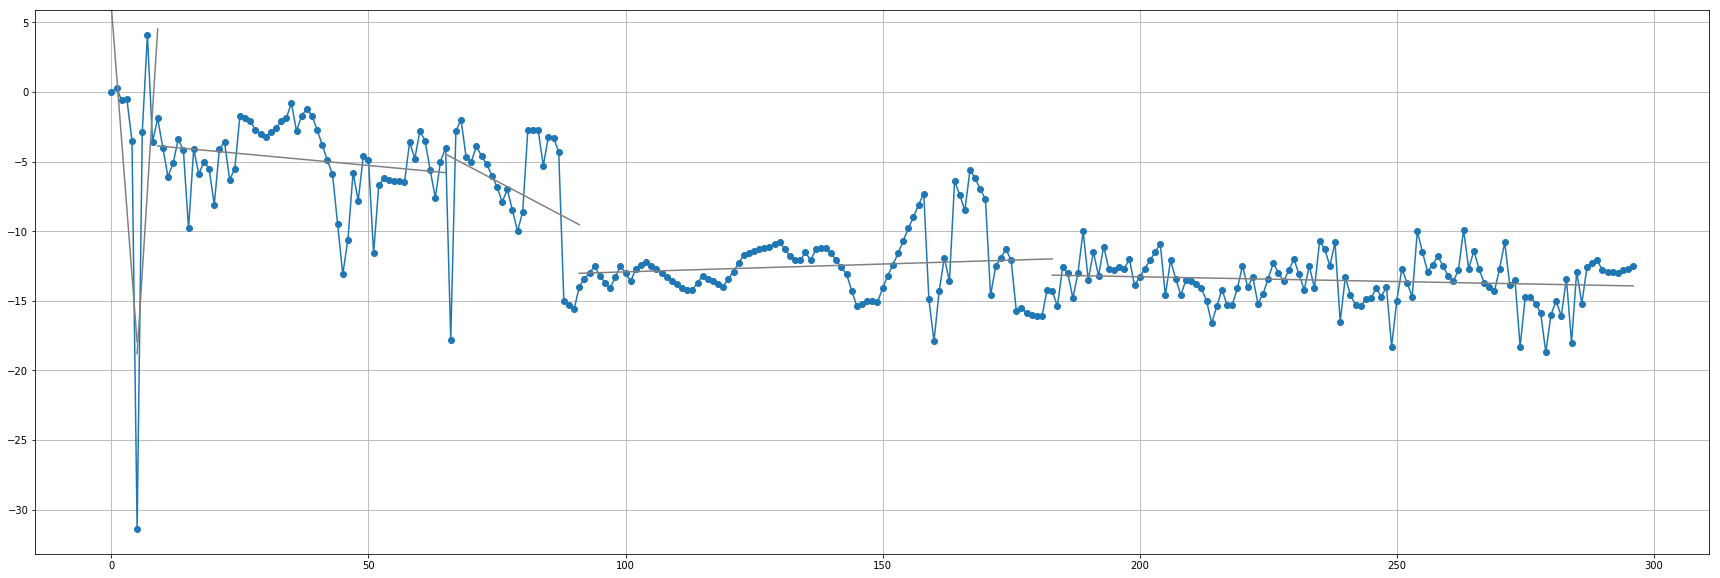

0
5
6
49
119
244


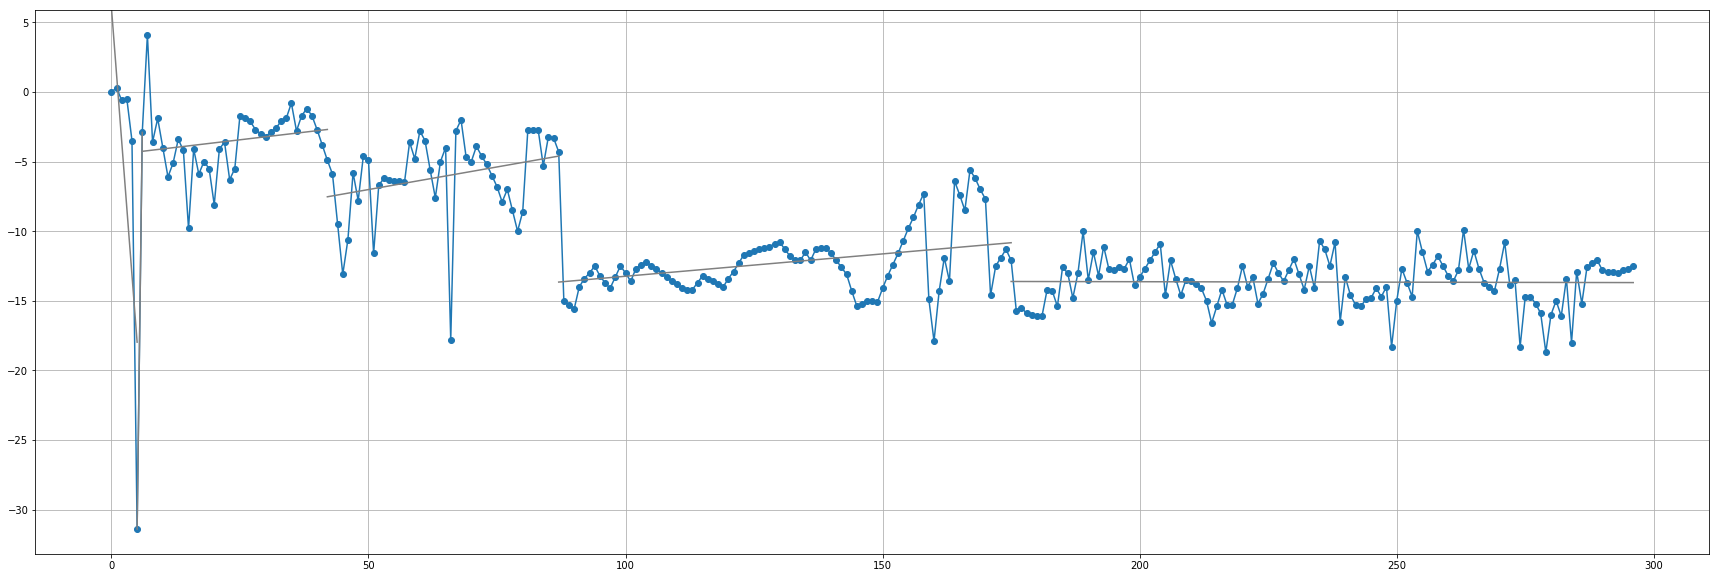

In [27]:
ts_num = 2
max_error = 500

plr_reg, _ = PLR_seg_reg(data.iloc[ans.index[ts_num]].values, max_error)

## For T-S with missing observations:`
# print("ans: ", ans.iloc[ts_num])
# print("ans: ", [indices[x] for x in ans.iloc[ts_num].values[0]])

## For full time T-S:
print("ans: ", ans_full.iloc[ts_num])


plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[1])
plt.title('Sliding window, #' + str( ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[0])
plt.title('Bottom up, #' + str( ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

plt.figure(figsize=(30,10))
plt.plot(data, '-o')
draw_segments(plr_reg[2])
plt.title('Top down, #' + str( ans.index[ts_num]), fontsize=22)
plt.grid()
plt.show()

In [23]:
# with open('PLR_all_results_100_2000.pkl', 'wb') as file:
#     pickle.dump(all_results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
all_results

{100: [(0.7007299270072993, 0.07084870848708487),
  (0.6131386861313869, 0.0691358024691358),
  (0.8686131386861314, 0.05997983870967742),
  (0.708029197080292, 0.07158671586715867),
  (0.6131386861313869, 0.0691358024691358),
  (0.8686131386861314, 0.06040609137055838)],
 200: [(0.49635036496350365, 0.09006622516556291),
  (0.4233576642335766, 0.0836940836940837),
  (0.7445255474452555, 0.09002647837599294),
  (0.49635036496350365, 0.09006622516556291),
  (0.4233576642335766, 0.0836940836940837),
  (0.7445255474452555, 0.09050576752440107)],
 300: [(0.3357664233576642, 0.08695652173913043),
  (0.34306569343065696, 0.09832635983263599),
  (0.6861313868613139, 0.11706102117061021),
  (0.34306569343065696, 0.0888468809073724),
  (0.34306569343065696, 0.09832635983263599),
  (0.6861313868613139, 0.11735330836454431)],
 400: [(0.3161764705882353, 0.10886075949367088),
  (0.30656934306569344, 0.11731843575418995),
  (0.6642335766423357, 0.14942528735632185),
  (0.33088235294117646, 0.113924

In [29]:

samples = [x * 100 for x in range(1,len(all_results)+1)]

recalls_sw = [all_results[i*100][3][0] for i in range(1,len(all_results)+1)]
precisions_sw = [all_results[i*100][3][1] for i in range(1,len(all_results)+1)]

recalls_bu = [all_results[i*100][4][0] for i in range(1,len(all_results)+1)]
precisions_bu = [all_results[i*100][4][1] for i in range(1,len(all_results)+1)]

recalls_td = [all_results[i*100][5][0] for i in range(1,len(all_results)+1)]
precisions_td = [all_results[i*100][5][1] for i in range(1,len(all_results)+1)]
f1score_td = [2*all_results[i*100][5][1]*all_results[i*100][5][0]/(all_results[i*100][5][1]+all_results[i*100][5][0]) for i in range(1,len(all_results)+1)]

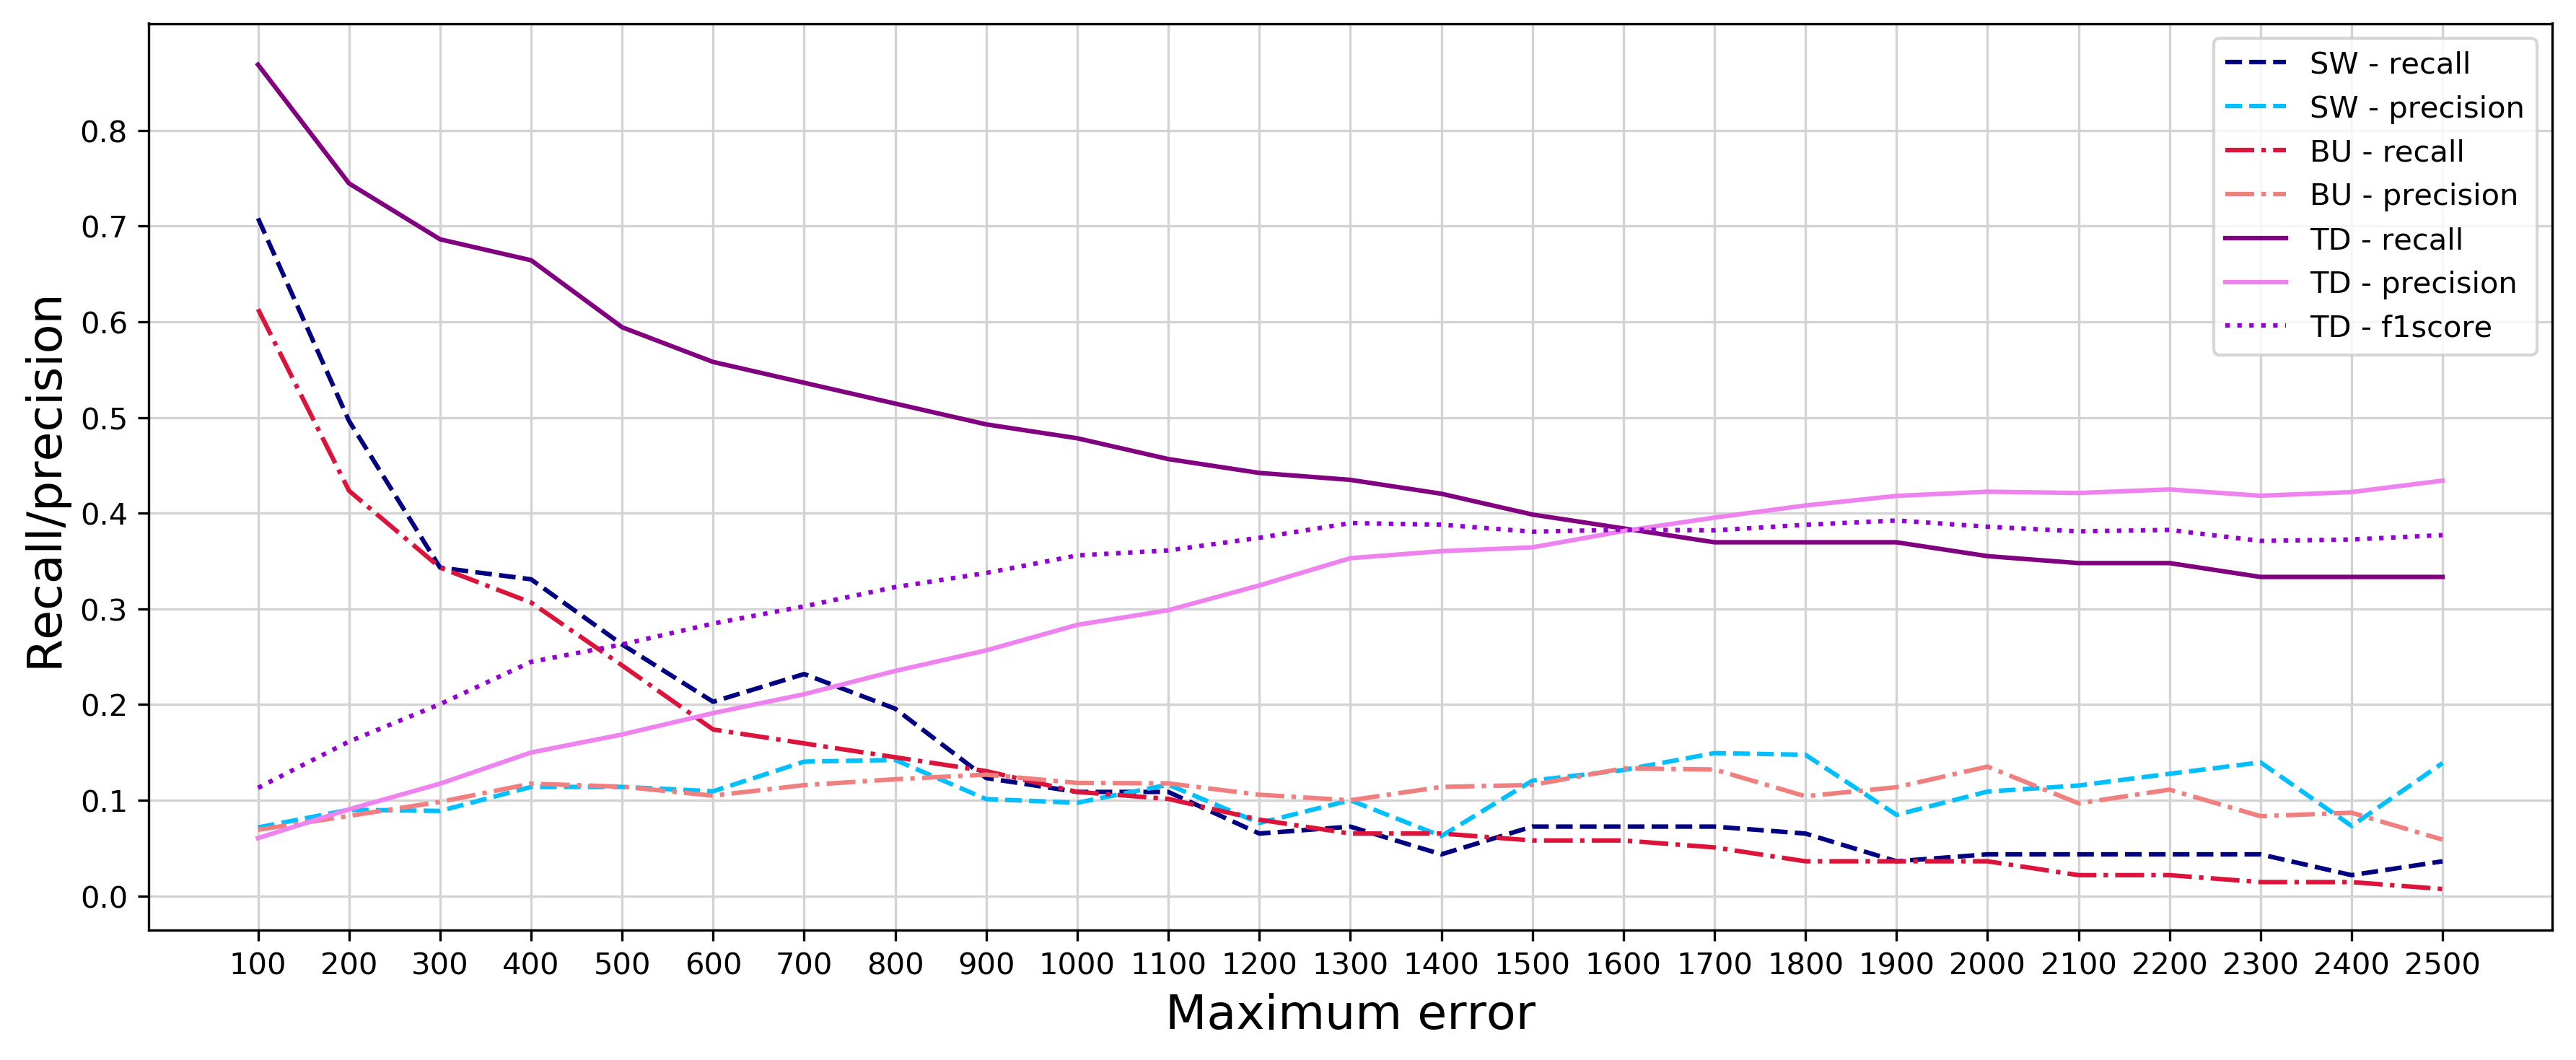

In [34]:
fig = plt.figure(figsize=(12,5), dpi=300)
ax = plt.gca()

ax.set_xlabel("Maximum error", fontsize=16)
ax.set_ylabel("Recall/precision", fontsize=16)
ax.grid(True)
ax.grid(color="lightgrey")

ax.plot(samples, recalls_sw, '--', label='SW - recall', c='navy')
ax.plot(samples, precisions_sw, '--', label='SW - precision', c='deepskyblue')

ax.plot(samples, recalls_bu, '-.', label= 'BU - recall', c = 'crimson')
ax.plot(samples, precisions_bu, '-.', label='BU - precision', c = 'lightcoral')

ax.plot(samples, recalls_td, '-', label = 'TD - recall', c = 'purple')
ax.plot(samples, precisions_td, '-', label = 'TD - precision', c = 'violet')
ax.plot(samples, f1score_td, linestyle='dotted', label = 'TD - f1score', c = 'darkviolet')

# ax.plot(samples, top_down_results, '-.', linewidth=2)

ax.set_xticks([(x * 100) for x in range(1,len(all_results)+1)])
ax.set_yticks([(x /10) for x in range(0,9)])

# ax.plot(samples, rec_avg, '--')
# ax.plot(samples, pre_avg, '--')

ax.legend()
fig.tight_layout()

### Save the plot ###
    
# fig.savefig('max_error_PLR_2500.jpg', bbox_inches="tight")    
plt.show()